In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import scipy.io as sio
from numpy import expand_dims
from numpy import asarray
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from skimage.filters import gabor_kernel
from scipy import ndimage as nd        
import matplotlib
import matplotlib.pyplot as plt    
from numpy.linalg import norm
from keras.optimizers import SGD, Adam, Adagrad
import graphviz
import pydot

In [2]:
data_path = 'E:/Sushree/Dataset/'

img_path = os.path.join(data_path,'Animals_with_Attributes2/JPEGImages/')
print(img_path)

print(len(os.listdir(img_path)))

def get_imlist(path, option):
    if option == 'jpg':
        return[os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    
def prepare_dataset(img_path, width, height, option):
    folder_list = os.listdir(img_path)
    num_classes = len(folder_list)
    images = []
    labels = []
    for i in range(len(folder_list)):
        print(i)
        img_list = get_imlist(os.path.join(img_path, folder_list[i]), option)
        for j in range(len(img_list)):
            img = image.load_img(img_list[j], target_size = (width, height))
            img = np.array(img)
            #img = np.true_divide(img,[255.0], out = None)
            img = np.divide(np.subtract(img, np.mean(img)), np.std(img))
            x = image.img_to_array(img)
            images.append(x)
            labels.append(i)
    images = np.array(images, dtype = np.float32)                             
    labels = to_categorical(labels, num_classes)                             
    return images, labels  


width, height, ch = 224, 224, 3
images, labels = prepare_dataset(img_path, width, height,'jpg')

print(images.shape)
print(len(labels))

E:/Sushree/Dataset/Animals_with_Attributes2/JPEGImages/
50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(37322, 224, 224, 3)
37322


In [3]:

split_path = os.path.join(data_path,'data/xlsa17/data/AWA2/att_splits.mat')
matcontent = sio.loadmat(split_path)
trainval_loc = matcontent['trainval_loc'].squeeze() - 1

print(trainval_loc, len(trainval_loc))

train_images = images[trainval_loc]
print(train_images.shape)

train_labels = labels[trainval_loc]
print(train_labels, train_labels.shape)


[21482 11452 21448 ...  7992 10388  5160] 23527
(23527, 224, 224, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (23527, 50)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 16
train_gen = DataGenerator(X_train, y_train, batch_size)   
val_gen = DataGenerator(X_val, y_val, batch_size)

In [5]:
model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model.summary()

# define new_model, with an additional dense(1024) layer after global average pooling  
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
pred = Dense(50, activation='softmax')(x)

new_model = Model(inputs = model.input, outputs = pred)
new_model.summary()


for layer in new_model.layers:
    layer.trainable = True
    

sgd = SGD(learning_rate = 1e-2, decay = 1e-6, momentum = 0.9, nesterov = True)
new_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

train_summary = new_model.fit(train_gen, epochs = 100, verbose = 1, callbacks = None, validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)
    

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, None, None,   16640       ['pool1_pool[0][0]']             
                                256)                                                              
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block1_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block1_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv3_block3_add (Add)         (None, None, None,   0           ['conv3_block2_out[0][0]',       
                                512)                              'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, None, None,   0           ['conv3_block3_add[0][0]']       
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, None, None,   0          ['conv4_block2_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block2_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block2_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block7_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block7_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block7_add (Add)         (None, None, None,   0           ['conv4_block6_out[0][0]',       
                                1024)                             'conv4_block7_3_bn[0][0]']      
                                                                                                  
 conv4_block7_out (Activation)  (None, None, None,   0           ['conv4_block7_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
          

                                                                                                  
 conv4_block10_2_relu (Activati  (None, None, None,   0          ['conv4_block10_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block10_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block10_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block10_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block13_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block13_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block15_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block18_add (Add)        (None, None, None,   0           ['conv4_block17_out[0][0]',      
                                1024)                             'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, None, None,   0          ['conv4_block18_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block18_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block1_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block1_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, None, None,   0          ['conv5_block1_2_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, None, None,   2099200     ['conv4_block23_out[0][0]']      
          

                                                                                                  
 conv5_block3_out (Activation)  (None, None, None,   0           ['conv5_block3_add[0][0]']       
                                2048)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense_1 (

73/73 [==============================] - 12s 158ms/step - loss: 0.2032 - accuracy: 0.9366 - val_loss: 1.0528 - val_accuracy: 0.7188
Epoch 48/100
73/73 [==============================] - 12s 158ms/step - loss: 0.2756 - accuracy: 0.9135 - val_loss: 0.8712 - val_accuracy: 0.7778
Epoch 49/100
73/73 [==============================] - 12s 158ms/step - loss: 0.2658 - accuracy: 0.9264 - val_loss: 0.8682 - val_accuracy: 0.7604
Epoch 50/100
73/73 [==============================] - 12s 158ms/step - loss: 0.2560 - accuracy: 0.9289 - val_loss: 0.8933 - val_accuracy: 0.7778
Epoch 51/100
73/73 [==============================] - 12s 158ms/step - loss: 0.2452 - accuracy: 0.9324 - val_loss: 0.9603 - val_accuracy: 0.7431
Epoch 52/100
73/73 [==============================] - 11s 157ms/step - loss: 0.2176 - accuracy: 0.9430 - val_loss: 1.2937 - val_accuracy: 0.7014
Epoch 53/100
73/73 [==============================] - 12s 158ms/step - loss: 0.2110 - accuracy: 0.9341 - val_loss: 1.0360 - val_accuracy: 0.746

In [6]:
def prepare_dataset2(img_path, width, height, option):
    folder_list = os.listdir(img_path)
    num_classes = len(folder_list)
    labels = []
    folder_names = []
    for i in range(len(folder_list)):
        print(i)
        img_list = get_imlist(os.path.join(img_path, folder_list[i]), option)
        for j in range(len(img_list)):
            labels.append(i)
            folder_names.append(folder_list[i])
    return labels, folder_names


width, height, ch = 224, 224, 3
labels_nocategorical, folder_names = prepare_dataset2(img_path, width, height,'jpg') 

print(len(labels_nocategorical), np.unique(labels_nocategorical))
print(len(folder_names), np.unique(folder_names))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
37322 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
37322 ['antelope' 'bat' 'beaver' 'blue+whale' 'bobcat' 'buffalo' 'chihuahua'
 'chimpanzee' 'collie' 'cow' 'dalmatian' 'deer' 'dolphin' 'elephant' 'fox'
 'german+shepherd' 'giant+panda' 'giraffe' 'gorilla' 'grizzly+bear'
 'hamster' 'hippopotamus' 'horse' 'humpback+whale' 'killer+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'otter' 'ox' 'persian+cat' 'pig'
 'polar+bear' 'rabbit' 'raccoon' 'rat' 'rhinoceros' 'seal' 'sheep'
 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger' 'walrus'
 'weasel' 'wolf' 'zebra']


In [7]:
replace_names = [('grizzly+bear','grizzly bear'), ('killer+whale','killer whale'), ('persian+cat','persian cat'),
                ('german+shepherd','german shepherd'), ('blue+whale','blue whale'), ('siamese+cat','siamese cat'),
                ('spider+monkey','spider monkey'),('humpback+whale','humpback whale'), ('giant+panda','giant panda'), 
                ('polar+bear', 'polar bear')]

for pair in replace_names:
    for idx, name in enumerate(folder_names):
        folder_names[idx] = name.replace(pair[0], pair[1])
        
for name in np.unique(folder_names):
    print(name)

antelope
bat
beaver
blue whale
bobcat
buffalo
chihuahua
chimpanzee
collie
cow
dalmatian
deer
dolphin
elephant
fox
german shepherd
giant panda
giraffe
gorilla
grizzly bear
hamster
hippopotamus
horse
humpback whale
killer whale
leopard
lion
mole
moose
mouse
otter
ox
persian cat
pig
polar bear
rabbit
raccoon
rat
rhinoceros
seal
sheep
siamese cat
skunk
spider monkey
squirrel
tiger
walrus
weasel
wolf
zebra


In [8]:
import gensim.downloader as api

print('Load pretrain w2v model')

model_name = 'word2vec-google-news-300'#best model
model = api.load(model_name)

dim_w2v = 300

counter_err = 0
feat_w2v = []
for name in folder_names:
    print(name)
    words = name.split(' ')
    if words[-1] == '':     #remove empty element
        words = words[:-1]
    w2v = np.zeros(dim_w2v)
    for w in words:
        try:
            w2v += model[w]
        except Exception as e:
            print(e)
            counter_err += 1
    w2v = w2v / len(words)        
    feat_w2v.append(w2v[np.newaxis, :])

print('counter_err ',counter_err)

feat_w2v = np.concatenate(feat_w2v,axis=0)
#feat_w2v[feat_w2v<0]=0
print(feat_w2v.shape)

Load pretrain w2v model
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
antelope
ante

moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moose
moos

In [9]:

train_attributes = feat_w2v[trainval_loc]
print(train_attributes, train_attributes.shape)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_attributes, test_size = 0.2, random_state = 42)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 16
train_gen = DataGenerator(X_train, y_train, batch_size)   
val_gen = DataGenerator(X_val, y_val, batch_size)

[[ 0.21289062 -0.00457764 -0.23632812 ... -0.13867188 -0.19921875
   0.17675781]
 [-0.08203125 -0.01379395 -0.3125     ...  0.16796875 -0.1640625
   0.32617188]
 [ 0.21289062 -0.00457764 -0.23632812 ... -0.13867188 -0.19921875
   0.17675781]
 ...
 [ 0.16308594  0.08300781 -0.38476562 ... -0.14746094  0.13574219
   0.08251953]
 [ 0.02001953  0.31445312 -0.27734375 ...  0.33007812 -0.37109375
   0.20605469]
 [-0.02600098  0.09814453 -0.5        ...  0.24707031  0.02258301
   0.24121094]] (23527, 300)


In [41]:

for layer in new_model.layers:
    layer.trainable = False

x = new_model.layers[-3].output       # shape should be (bs=None, 2048)
x = Dense(1024, activation='relu')(x) # shape should be (bs=None, 1024)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x) # shape should be (bs=None, 512)
x = BatchNormalization()(x)
y = Dense(300, activation='linear')(x) # shape should be (bs=None, num_champti

model2 = Model(inputs = new_model.input, outputs=y)
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

In [42]:
# the loss function as an inverse cosine distance
def cosine_loss(y, y_hat):
    # unit-normalize y and y_hat ()
    y = tf.math.l2_normalize(y, axis = 1)
    y_hat = tf.math.l2_normalize(y_hat, axis = 1)
    # cosine distance for normalized tensors
    loss = tf.compat.v1.losses.cosine_distance(y, y_hat, axis=1)
    return loss

In [43]:

adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.01, decay = 0.0001)
#model2.compile(adam, loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.AUTO), metrics = ['accuracy'])
model2.compile(adam, loss = cosine_loss, metrics = ['accuracy'])

#CosineSimilarity is a number between -1 and 1. When it is a negative number between -1 and 0, 0 indicates orthogonality and 
#values closer to -1 indicate greater similarity. The values closer to 1 indicate greater dissimilarity. 

save_path = 'C:/Users/Admin/Sushree_Codes/Sush_2/Results/'
name = 'visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_AWA2_200eph_adam_cosine2_16bch_0.001lr'
file_path = save_path + 'bw_' + name + '.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = file_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True)

train_summary = model2.fit(train_gen, epochs = 200, verbose = 1, callbacks = [model_checkpoint_callback], validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)

Epoch 1/200
73/73 [==============================] - 10s 80ms/step - loss: 0.9394 - accuracy: 0.0137 - val_loss: 0.8765 - val_accuracy: 0.0174
Epoch 2/200
73/73 [==============================] - 5s 63ms/step - loss: 0.7714 - accuracy: 0.0137 - val_loss: 0.7397 - val_accuracy: 0.0556
Epoch 3/200
73/73 [==============================] - 4s 55ms/step - loss: 0.6359 - accuracy: 0.0351 - val_loss: 0.6222 - val_accuracy: 0.0556
Epoch 4/200
73/73 [==============================] - 5s 63ms/step - loss: 0.5421 - accuracy: 0.0582 - val_loss: 0.5214 - val_accuracy: 0.0938
Epoch 5/200
73/73 [==============================] - 5s 63ms/step - loss: 0.4748 - accuracy: 0.0848 - val_loss: 0.4399 - val_accuracy: 0.1632
Epoch 6/200
73/73 [==============================] - 5s 63ms/step - loss: 0.4205 - accuracy: 0.1019 - val_loss: 0.3942 - val_accuracy: 0.2188
Epoch 7/200
73/73 [==============================] - 5s 63ms/step - loss: 0.3837 - accuracy: 0.1464 - val_loss: 0.3482 - val_accuracy: 0.2326
Epoch

73/73 [==============================] - 4s 57ms/step - loss: 0.0633 - accuracy: 0.5471 - val_loss: 0.1154 - val_accuracy: 0.5347
Epoch 59/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0703 - accuracy: 0.5351 - val_loss: 0.1208 - val_accuracy: 0.5451
Epoch 60/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0726 - accuracy: 0.5625 - val_loss: 0.1141 - val_accuracy: 0.5521
Epoch 61/200
73/73 [==============================] - 5s 67ms/step - loss: 0.0651 - accuracy: 0.5685 - val_loss: 0.1135 - val_accuracy: 0.5694
Epoch 62/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0684 - accuracy: 0.5522 - val_loss: 0.1157 - val_accuracy: 0.5347
Epoch 63/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0695 - accuracy: 0.5539 - val_loss: 0.1197 - val_accuracy: 0.5486
Epoch 64/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0718 - accuracy: 0.5753 - val_loss: 0.1139 - val_accuracy: 0.5556
Epoch 65/200

73/73 [==============================] - 4s 57ms/step - loss: 0.0600 - accuracy: 0.6104 - val_loss: 0.1079 - val_accuracy: 0.5903
Epoch 116/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0587 - accuracy: 0.6079 - val_loss: 0.1093 - val_accuracy: 0.5972
Epoch 117/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0588 - accuracy: 0.5925 - val_loss: 0.1154 - val_accuracy: 0.5972
Epoch 118/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0581 - accuracy: 0.6207 - val_loss: 0.1075 - val_accuracy: 0.5938
Epoch 119/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0612 - accuracy: 0.5719 - val_loss: 0.1067 - val_accuracy: 0.6007
Epoch 120/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0610 - accuracy: 0.5539 - val_loss: 0.1067 - val_accuracy: 0.5938
Epoch 121/200
73/73 [==============================] - 5s 65ms/step - loss: 0.0614 - accuracy: 0.6113 - val_loss: 0.1120 - val_accuracy: 0.6042
Epoch 

Epoch 172/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0534 - accuracy: 0.6283 - val_loss: 0.1052 - val_accuracy: 0.5729
Epoch 173/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0551 - accuracy: 0.5993 - val_loss: 0.1051 - val_accuracy: 0.5833
Epoch 174/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0559 - accuracy: 0.6087 - val_loss: 0.1049 - val_accuracy: 0.5868
Epoch 175/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0565 - accuracy: 0.5890 - val_loss: 0.1045 - val_accuracy: 0.5764
Epoch 176/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0548 - accuracy: 0.6190 - val_loss: 0.1044 - val_accuracy: 0.5799
Epoch 177/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0570 - accuracy: 0.5925 - val_loss: 0.1039 - val_accuracy: 0.5799
Epoch 178/200
73/73 [==============================] - 4s 57ms/step - loss: 0.0529 - accuracy: 0.6147 - val_loss: 0.1051 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


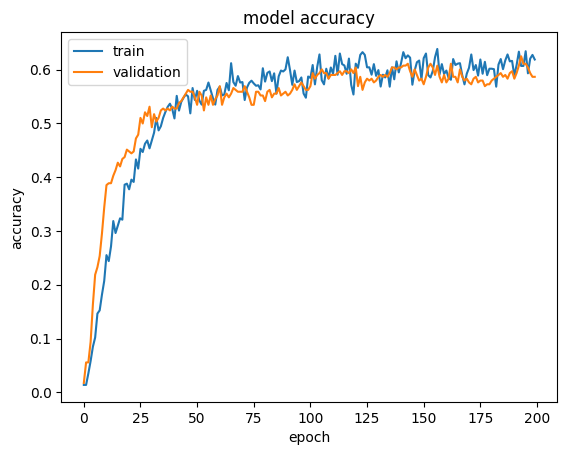

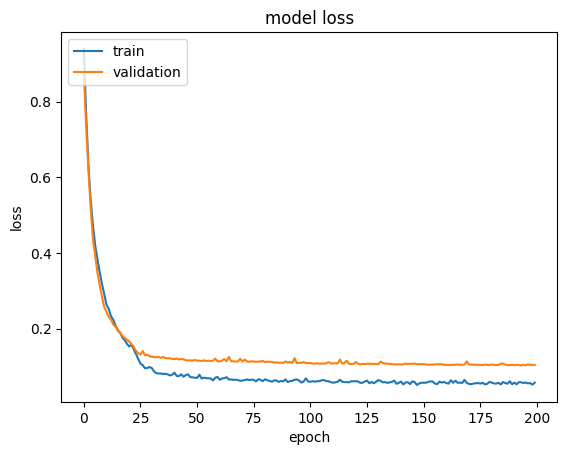

<Figure size 640x480 with 0 Axes>

In [44]:

model2.save_weights(save_path + 'Wt_' + name + '.h5')

print(train_summary.history.keys())

plt.plot(train_summary.history['accuracy'])
plt.plot(train_summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Acc_' + name + '.png')

plt.plot(train_summary.history['loss'])
plt.plot(train_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Loss_' + name + '.png')

In [45]:
attribute_length = 300

test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
print(test_seen_loc, len(test_seen_loc))

test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
print(test_unseen_loc, len(test_unseen_loc))

test_seen_images = images[test_seen_loc]
print(test_seen_images.shape)

test_unseen_images = images[test_unseen_loc]
print(test_unseen_images.shape)

test_seen_attributes = feat_w2v[test_seen_loc]
print(test_seen_attributes, test_seen_attributes.shape)

test_unseen_attributes = feat_w2v[test_unseen_loc]
print(test_unseen_attributes, test_unseen_attributes.shape)

[11060  6270 17297 ...  4013 20614 33201] 5882
[ 1046  1047  1048 ... 35288 35289 35290] 7913
(5882, 224, 224, 3)
(7913, 224, 224, 3)
[[-0.08203125 -0.01379395 -0.3125     ...  0.16796875 -0.1640625
   0.32617188]
 [ 0.18945312 -0.07519531 -0.15625    ...  0.08789062 -0.08789062
  -0.11523438]
 [ 0.09863281  0.10449219 -0.16113281 ...  0.15625    -0.24023438
   0.04541016]
 ...
 [ 0.10302734 -0.12158203 -0.07226562 ...  0.50390625 -0.48046875
   0.16308594]
 [ 0.07861328  0.00439453 -0.546875   ...  0.24804688  0.08203125
   0.33007812]
 [-0.14453125 -0.0234375  -0.39648438 ...  0.12988281  0.08398438
   0.09960938]] (5882, 300)
[[-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 [-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 [-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 ...
 [-0.04760742  0.15917969 -0.39257812 ...  0.45703125  0.08984375
   0.10742188]
 [-0.04760742  0.15917969 -0.39257

In [46]:
test_seen_gen = DataGenerator(test_seen_images, test_seen_attributes, batch_size)
model2.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_attributes, batch_size)
model2.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)

30/30 [==============================] - 1s 44ms/step - loss: 0.6462 - accuracy: 0.0083


[0.6461679339408875, 0.008333333767950535]

In [47]:
attribute_length = 300

test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
print(test_seen_loc, len(test_seen_loc))

test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
print(test_unseen_loc, len(test_unseen_loc))

test_seen_images = images[test_seen_loc]
print(test_seen_images.shape)

test_unseen_images = images[test_unseen_loc]
print(test_unseen_images.shape)

test_seen_attributes = feat_w2v[test_seen_loc]
print(test_seen_attributes, test_seen_attributes.shape)

test_unseen_attributes = feat_w2v[test_unseen_loc]
print(test_unseen_attributes, test_unseen_attributes.shape)

[11060  6270 17297 ...  4013 20614 33201] 5882
[ 1046  1047  1048 ... 35288 35289 35290] 7913
(5882, 224, 224, 3)
(7913, 224, 224, 3)
[[-0.08203125 -0.01379395 -0.3125     ...  0.16796875 -0.1640625
   0.32617188]
 [ 0.18945312 -0.07519531 -0.15625    ...  0.08789062 -0.08789062
  -0.11523438]
 [ 0.09863281  0.10449219 -0.16113281 ...  0.15625    -0.24023438
   0.04541016]
 ...
 [ 0.10302734 -0.12158203 -0.07226562 ...  0.50390625 -0.48046875
   0.16308594]
 [ 0.07861328  0.00439453 -0.546875   ...  0.24804688  0.08203125
   0.33007812]
 [-0.14453125 -0.0234375  -0.39648438 ...  0.12988281  0.08398438
   0.09960938]] (5882, 300)
[[-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 [-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 [-0.34570312  0.32421875  0.15722656 ...  0.12060547 -0.01623535
  -0.00326538]
 ...
 [-0.04760742  0.15917969 -0.39257812 ...  0.45703125  0.08984375
   0.10742188]
 [-0.04760742  0.15917969 -0.39257

In [48]:
model2.load_weights(save_path + 'bw_' + name + '.h5')

test_seen_gen = DataGenerator(test_seen_images, test_seen_attributes, batch_size)
model2.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_attributes, batch_size)
model2.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)


30/30 [==============================] - 1s 44ms/step - loss: 0.6479 - accuracy: 0.0104


[0.6478789448738098, 0.010416666977107525]

# Results

visual_to_class_w2vT_300_embedding_1024_AWA2_100eph_adam_cosine_16bch_0.001lr 
[w2v of 300 length extracted, negative values are made 0, additional: (Dense 1024, batchnorm), weights of ResNet101 is also updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 100/100
loss: -0.7420 - accuracy: 0.1344 - val_loss: -0.7432 - val_accuracy: 0.1944

test seen: loss: -0.7416 - accuracy: 0.1576
test unseen: loss: -0.5608 - accuracy: 0.0000e+00

visual_to_class_w2vT1_300_embedding_1024_AWA2_100eph_adam_cosine_16bch_0.001lr
[w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of ResNet101 is also updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 100/100
loss: -0.6664 - accuracy: 0.1567 - val_loss: -0.6376 - val_accuracy: 0.2153

test seen: loss: -0.6274 - accuracy: 0.1848
test unseen: loss: -0.3454 - accuracy: 0.0021

visual_to_class_w2vT1_300_embedding_1024_AWA2_100eph_adam_cosine2_16bch_0.001lr
[w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of ResNet101 is also updated, adam optimizer, lr = 0.001, cosine loss modified (0 to 1)]

training: 
Epoch 100/100
loss: 0.3403 - accuracy: 0.1524 - val_loss: 0.3515 - val_accuracy: 0.2118

test seen: loss: 0.3488 - accuracy: 0.1658
test unseen: loss: 0.6564 - accuracy: 0.0000e+00

visualFT_to_class_w2vT1_300_embedding_1024_AWA2_100eph_adam_cosine2_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of new_model is also updated, adam optimizer, lr = 0.001, cosine loss modified (0 to 1)]

training: 
Epoch 100/100
loss: 0.0520 - accuracy: 0.6182 - val_loss: 0.1197 - val_accuracy: 0.5868

test seen: loss: 0.1173 - accuracy: 0.5788
test unseen: loss: 0.7166 - accuracy: 0.0000e+00

visualFT_to_class_w2vT1_300_embedding_1024_AWA2_100eph_adam_cosine_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of new_model is also updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 100/100
loss: -0.6553 - accuracy: 0.2423 - val_loss: -0.7138 - val_accuracy: 0.2604

test seen: loss: -0.7422 - accuracy: 0.2609
test unseen: loss: -0.3203 - accuracy: 0.1125

With best weights
test seen: loss: -0.8767 - accuracy: 0.5652
test unseen: loss: -0.2001 - accuracy: 0.0688

visualFT_to_class_w2vT1_300_embedding_noFT_1024_AWA2_100eph_adam_cosine_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 100/100
loss: -0.9344 - accuracy: 0.5745 - val_loss: -0.8919 - val_accuracy: 0.5729

test seen: loss: -0.8991 - accuracy: 0.5353
test unseen: loss: -0.3516 - accuracy: 0.0208

With best weights
test seen: loss: -0.8982 - accuracy: 0.5435
test unseen: loss: -0.3491 - accuracy: 0.0271

visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_AWA2_200eph_adam_cosine_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm, dense 512, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 200/200
loss: -0.9440 - accuracy: 0.5865 - val_loss: -0.8939 - val_accuracy: 0.6250

test seen: loss: -0.9021 - accuracy: 0.5815
test unseen: loss: -0.3472 - accuracy: 0.0000e+00

With best weights
test seen: loss: -0.9052 - accuracy: 0.6060
test unseen: loss: -0.3528 - accuracy: 0.0063

visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_AWA2_200eph_adam_cosine2_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm, dense 512, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss modified (0 to 1)]

training: 
Epoch 200/200
loss: 0.0574 - accuracy: 0.6190 - val_loss: 0.1043 - val_accuracy: 0.5868

test seen: loss: 0.0958 - accuracy: 0.5679
test unseen: loss: 0.6462 - accuracy: 0.0083

With best weights
test seen: loss: 0.0939 - accuracy: 0.5815
test unseen: loss: 0.6479 - accuracy: 0.0104
